# Dog Breed Classication Using AWS SageMaker

We will use AWS Sagemaker to finetune a pretrained model that can perform image classification. We will use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering techniques.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import io
import pickle
import requests

In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [4]:
print(f"Bucket: {bucket}")
print(f"Role: {role}")

Bucket: sagemaker-us-east-1-827890247790
Role: arn:aws:iam::827890247790:role/service-role/AmazonSageMaker-ExecutionRole-20220707T233083


## Dataset
#### We will use the dog breed classication dataset to classify between different breeds of dogs in images. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [6]:
# Upload data to the s3 bucket
#data = sagemaker_session.upload_data(path='dogImages', bucket=bucket, key_prefix='image_classification')

In [7]:
# Saving the s3 data path
inputs = "s3://sagemaker-us-east-1-827890247790/image_classification"

In [8]:
print(f'data s3 path: {inputs}')

data s3 path: s3://sagemaker-us-east-1-827890247790/image_classification


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#TODO: Declare your HP ranges, metrics etc.

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs, 
    DebuggerHookConfig, ProfilerConfig, FrameworkProfile,
)

In [10]:
# define hyperparameters
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(5, 10),
    "momentum": ContinuousParameter(0.5, 0.9),
}

In [11]:
#TODO: Create estimators for your HPs

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
) # TODO: Your HP tuner here

In [12]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-08-11 07:12:13 Starting - Preparing the instances for training
2022-08-11 07:12:13 Downloading - Downloading input data
2022-08-11 07:12:13 Training - Training image download completed. Training in progress.
2022-08-11 07:12:13 Uploading - Uploading generated training model
2022-08-11 07:12:13 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '10',
 'lr': '0.05032814473263994',
 'momentum': '0.7956512926378554',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-08-11-06-13-22-241"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-06-13-22-241/source/sourcedir.tar.gz"'}

In [15]:
best_hyperparameters = {
    "lr": best_estimator.hyperparameters()["lr"], 
    "batch-size": best_estimator.hyperparameters()["batch-size"].replace('"', ""),
    "epochs": best_estimator.hyperparameters()["epochs"],
    "momentum": best_estimator.hyperparameters()["momentum"],
}

best_hyperparameters

{'lr': '0.05032814473263994',
 'batch-size': '32',
 'epochs': '10',
 'momentum': '0.7956512926378554'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configure-framework-profiling.html

In [16]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [17]:
# TODO: Create and fit an estimator

best_estimator = PyTorch(
    entry_point="train_model.py",
    framework_version="1.6", 
    py_version="py36",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=best_hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
) # TODO: Your estimator here

In [18]:
# fit estimator
best_estimator.fit({"training": inputs}, wait=True)

2022-08-11 07:23:28 Starting - Starting the training job...
2022-08-11 07:23:58 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-08-11 07:25:18 Downloading - Downloading input data............
2022-08-11 07:27:19 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-11 07:27:38,609 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-11 07:27:38,634 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-11 07:27:38,643 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-11 07:27:39,128 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channe

In [19]:
# TODO: Plot a debugging output.

# retrieve s3 location of debugger tensors
tensors_path = best_estimator.latest_job_debugger_artifacts_path()
print("S3 path to debugger tensors: ", tensors_path)

S3 path to debugger tensors:  s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/debug-output


https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb

https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-enable-tensorboard-summaries.html

In [20]:
# Create an smdebug Trial object

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(tensors_path)

# tensor names
test_tensor = trial.tensor_names(regex=".*output")[0]
test_tensor

[2022-08-11 07:54:11.121 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:156 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-11 07:54:11.136 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:156 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/debug-output
[2022-08-11 07:54:14.097 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:156 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-08-11 07:54:15.141 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:156 INFO trial.py:210] Loaded all steps


'CrossEntropyLoss_output_0'

In [21]:
# create functions to plot an output tensor

from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    values = []
    for step in steps:
        values.append(tensor.value(step, mode=mode))
    return steps, values


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


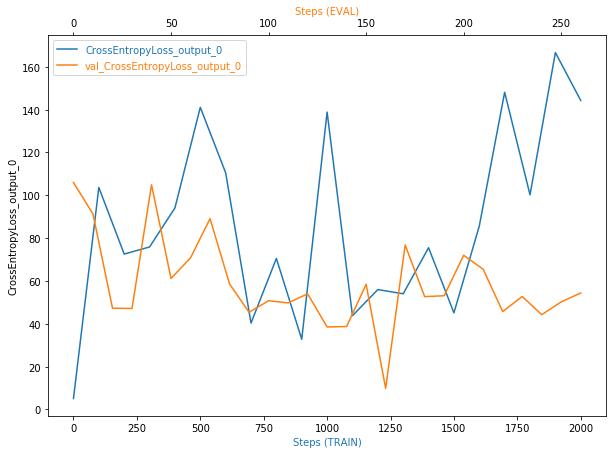

In [22]:
plot_tensor(trial, test_tensor)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it? 

The debugging output has detected vanishing gradients, overfit and poor weight initialization issues.

We can try fixing these problems by increasing hyperparameter range and also changing model type.

https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html

In [27]:
rule_output_path = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive

2022-08-11 07:52:08     418112 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-08-11 07:52:07     273908 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-08-11 07:52:03        192 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-08-11 07:52:03      49055 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-08-11 07:52:03        126 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-08-11 07:52:03        329 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-08-11 07:52:03       2445 pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-re

In [29]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-827890247790/pytorch-training

In [31]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in best_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [32]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=best_estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

-------

In [115]:
model_data = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-827890247790/pytorch-training-2022-08-11-07-23-28-228/output/model.tar.gz


In [116]:
# Implement inference.py file from project4.
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8"
)

In [117]:
predictor1 = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [114]:
#!pip install --upgrade pip
#!pip install torch torchvision --no-cache-dir
#!pip install torch

In [118]:
# Run an prediction on the endpoint
from torchvision import transforms

In [119]:
# inference fnction takes an image path, processes it, and uses the endpoint for prediction
def inference(path):
    image = Image.open(path)

    transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    transformed_image = transform(image).unsqueeze(0)
    transformed_image = transformed_image.to("cpu")

    response = predictor1.predict(transformed_image)
    pred = np.argmax(response, 1)+1
    plt.imshow(Image.open(path))
    plt.show()
    print(f"Actual: {int(path[17:20])}, Prediction: {pred[0]}")

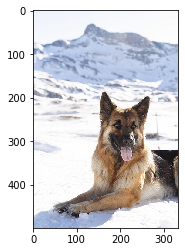

Actual: 71, Prediction: 129
---------------------------------------- 



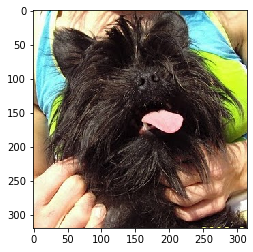

Actual: 1, Prediction: 133
---------------------------------------- 



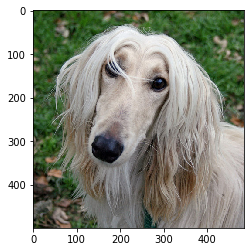

Actual: 2, Prediction: 130
---------------------------------------- 



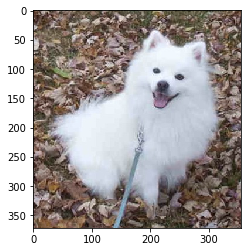

Actual: 6, Prediction: 123
---------------------------------------- 



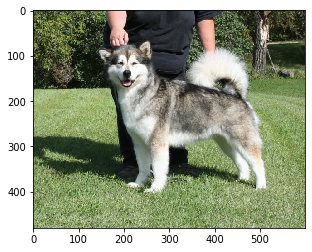

Actual: 5, Prediction: 123
---------------------------------------- 



In [127]:
# TODO: Run an prediction on the endpoint

images = ['./dogImages/test/071.German_shepherd_dog/German_shepherd_dog_04886.jpg', 
               "./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", 
               "./dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg", 
               "./dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00407.jpg", 
               "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00375.jpg"]

for img in images:
    inference(img)
    print("-"*40, '\n')

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()